In [1]:
using Pkg
Pkg.activate("/media/mat/HDD/AdaptiveTransportMap/")

 Activating environment at `/media/mat/HDD/AdaptiveTransportMap/Project.toml`


In [2]:
using Revise
using AdaptiveTransportMap
using LinearAlgebra
import LinearAlgebra: ldiv!, dot
using Test
using ForwardDiff
using BenchmarkTools
using TransportMap
using QuadGK
using Distributions
using Random
using LoopVectorization
using Test
using SparseArrays
using AdaptiveTransportMap: vander, transform!, evaluate, ncoeff, optimize, negative_log_likelihood!, derivative
using Quadrature
using Cubature
using FiniteDiff
using Test

### Gradient and Hessian of the log pdf

In [3]:
using LinearAlgebra
using SparseArrays 

N = 200
Nx = 20

dim = [1; 2; 5; 8; 10; 14; 17; 20]

@time A  = sparse(repeat(1:N, length(dim)), vcat([i*ones(Int64, N) for i in dim]...), zeros(N*length(dim)), N, Nx)

  0.293979 seconds (851.98 k allocations: 43.569 MiB, 3.90% gc time)


200×20 SparseMatrixCSC{Float64,Int64} with 1600 stored entries:
  [1  ,  1]  =  0.0
  [2  ,  1]  =  0.0
  [3  ,  1]  =  0.0
  [4  ,  1]  =  0.0
  [5  ,  1]  =  0.0
  [6  ,  1]  =  0.0
  [7  ,  1]  =  0.0
  [8  ,  1]  =  0.0
  [9  ,  1]  =  0.0
  [10 ,  1]  =  0.0
  [11 ,  1]  =  0.0
  [12 ,  1]  =  0.0
  ⋮
  [188, 20]  =  0.0
  [189, 20]  =  0.0
  [190, 20]  =  0.0
  [191, 20]  =  0.0
  [192, 20]  =  0.0
  [193, 20]  =  0.0
  [194, 20]  =  0.0
  [195, 20]  =  0.0
  [196, 20]  =  0.0
  [197, 20]  =  0.0
  [198, 20]  =  0.0
  [199, 20]  =  0.0
  [200, 20]  =  0.0

In [3]:
Nx = 8
Ne = 100
m = 10

X = randn(Nx, Ne) .* randn(Nx, Ne) .+ randn(Nx)

idx =  [ 0  0  0  0  0  1  0  1
         0  0  0  0  4  0  0  2
         0  1  2  3  0  0  1  0
         0  0  0  1  0  0  0  0
         0  0  1  0  0  3  0  0]

coeff =  [   0.7826236383247712
              1.6396512186057377
              1.2687650163074022
             -0.8193039185231135
             -0.8190203466485412];

In [4]:
C = MapComponent(m, Nx, idx, coeff)
R = C.I;

In [5]:
Ht = zeros(Nx, Nx)
function Hessian!(H, x)
    fill!(H, 0.0)

    H[1:Nx-1,1:Nx-1] .= ForwardDiff.hessian(y->begin
                        y[Nx] = 0.0
                        return R.f.f(y) end, x)[1:Nx-1,1:Nx-1]

    # Hessian of the integral term
    H[1:Nx-1,1:Nx-1] .+= (quadgk(t -> ForwardDiff.hessian(
    z-> R.g(ForwardDiff.gradient(y->R.f.f(y), vcat(z[1:end-1], t))[end]), x),
            0.0, x[end], rtol = 1e-3)[1])[1:Nx-1,1:Nx-1]

    # H[Nx,:] and H[:,Nx]
    H[:, Nx] .= ForwardDiff.gradient(z->R.g(ForwardDiff.gradient(y->R.f.f(y), z)[end]), x)
    H[Nx, :] .= H[:, Nx]
    return H
end

Hessian! (generic function with 1 method)

In [6]:
@time Ht = Hessian!(Ht, X[:,1])

 51.187520 seconds (37.95 M allocations: 1.505 GiB, 0.66% gc time)


8×8 Array{Float64,2}:
 0.0   0.0           0.0           0.0         …   0.0           0.0
 0.0  -0.0657341    -0.000938351  -0.00139567      0.000217964   0.0
 0.0  -0.000938351  -0.124731      0.00976066     -0.00152434    0.0
 0.0  -0.00139567    0.00976066   -0.29276        -0.00226724    0.0
 0.0   0.0           0.0           0.0             0.0          -0.0107631
 0.0   0.0           0.00412795    0.0         …   0.0          -0.020767
 0.0   0.000217964  -0.00152434   -0.00226724     -0.0655142     0.0
 0.0   0.0           0.0           0.0             0.0           0.0741613

In [9]:
@time H = hess_x(R, X)[1,:,:]

  0.004343 seconds (16.90 k allocations: 7.711 MiB)


8×8 Array{Float64,2}:
 0.0   0.0           0.0           0.0         …   0.0           0.0
 0.0  -0.0657341    -0.000938351  -0.00139567      0.000217964   0.0
 0.0  -0.000938351  -0.124731      0.00976066     -0.00152434    0.0
 0.0  -0.00139567    0.00976066   -0.29276        -0.00226724    0.0
 0.0   0.0           0.0           0.0             0.0          -0.0107631
 0.0   0.0           0.00412795    0.0         …   0.0          -0.020767
 0.0   0.000217964  -0.00152434   -0.00226724     -0.0655142     0.0
 0.0   0.0           0.0           0.0             0.0           0.0741613

In [10]:
H-Ht

8×8 Array{Float64,2}:
 0.0   0.0           0.0          0.0          …   0.0           0.0
 0.0   0.0          -5.42101e-19  0.0             -8.13152e-20   0.0
 0.0  -5.42101e-19   2.77556e-17  1.04083e-17     -1.0842e-18    0.0
 0.0   0.0           1.04083e-17  1.11022e-16      0.0           0.0
 0.0   0.0           0.0          0.0              0.0           9.71445e-17
 0.0   0.0          -2.94903e-17  0.0          …   0.0          -3.46945e-18
 0.0  -8.13152e-20  -1.0842e-18   0.0              4.16334e-17   0.0
 0.0   0.0           0.0          0.0              0.0           4.16334e-17

In [42]:
A = spzeros(200, 50)

200×50 SparseMatrixCSC{Float64,Int64} with 0 stored entries

In [48]:
@time A[:, C.I.f.f.dim] .= 1.0

  0.000093 seconds (13 allocations: 1024 bytes)


200×7 view(::SparseMatrixCSC{Float64,Int64}, :, [2, 3, 4, 5, 6, 7, 8]) with eltype Float64:
 1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0
 ⋮                        ⋮    
 1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0

In [44]:
Nx = 8
Ne = 100
ens = EnsembleState(Nx, Ne)

ens.S .= randn(Nx, Ne)

B = MultiBasis(CstProHermite(10), Nx)

idx =  [ 0  0  0  0  0  1  0  1
         0  0  0  0  2  0  0  2
         0  1  2  3  0  0  1  0
         0  0  0  1  0  0  0  0
         0  0  1  0  0  2  0  0]

coeff =  [   0.7826236383247712
              1.6396512186057377
              1.2687650163074022
             -0.8193039185231135
             -0.8190203466485412];

Nψ = 5
f = ExpandedFunction(B, idx, coeff)
fp = ParametricFunction(f);
R = IntegratedFunction(fp)

# Test grad_x
dψ = grad_x(R, ens.S)

function Gradient(x)
    return ForwardDiff.gradient(y->begin
                           y[end] = 0.0
                           return  R.f.f(y)
        end, x) + quadgk(t->ForwardDiff.gradient(
                  z->R.g(ForwardDiff.gradient(y->R.f.f(y), vcat(z[1:end-1],t))[end]),
            x), 0.0, x[end])[1] + vcat(zeros(size(x,1)-1), R.g(ForwardDiff.gradient(y->R.f.f(y), x)[end]))
end

for i=1:Ne
    xi = member(ens, i)
    dψt = Gradient(xi)
    @test norm(dψ[i,:] - dψt)<1e-8
end

# Test hess_x
H = hess_x(R, ens.S)
function Hessian(x)
    out = zeros(Nx, Nx)

    out[1:Nx-1,1:Nx-1] .= ForwardDiff.hessian(y->begin
                        y[Nx] = 0.0
                        return R.f.f(y) end, x)[1:Nx-1,1:Nx-1]

    # Hessian of the integral term
    out[1:Nx-1,1:Nx-1] .+= (quadgk(t -> ForwardDiff.hessian(
    z-> R.g(ForwardDiff.gradient(y->R.f.f(y), vcat(z[1:end-1], t))[end]), x),
            0.0, x[end], rtol = 1e-5)[1])[1:Nx-1,1:Nx-1]

    # H[Nx,:] and H[:,Nx]
    out[:, Nx] .= ForwardDiff.gradient(z->R.g(ForwardDiff.gradient(y->R.f.f(y), z)[end]), x)
    out[Nx, :] .= out[:, Nx]
    return out
end

# @inbounds for i=1:Ne
#     @test norm(H[i,:,:] - Hessian(member(ens,i)))<1e-8
# end

Hessian (generic function with 1 method)

In [49]:
Hessian(member(ens,1))'

8×8 Adjoint{Float64,Array{Float64,2}}:
 0.0   0.0         0.0         0.0        …   0.0         0.0
 0.0  -0.0105144  -0.0150726   0.0201346     -0.0122325   0.0
 0.0  -0.0150726  -0.0230335   0.0156099     -0.00948359  0.0
 0.0   0.0201346   0.0156099   0.275446       0.0126686   0.0
 0.0   0.0         0.0         0.0            0.0         0.0666631
 0.0   0.0         0.0890275   0.0        …   0.0         0.0170236
 0.0  -0.0122325  -0.00948359  0.0126686      0.00123048  0.0
 0.0   0.0         0.0         0.0            0.0         0.232179

In [50]:
(H[1,:,:]-Hessian(member(ens,1)))

8×8 Array{Float64,2}:
 0.0  0.0           0.0          0.0  …  0.0           0.0
 0.0  5.20417e-18   1.73472e-18  0.0     1.73472e-18   0.0
 0.0  1.73472e-18  -3.46945e-18  0.0     1.73472e-18   0.0
 0.0  0.0           0.0          0.0     0.0           0.0
 0.0  0.0           0.0          0.0     0.0           1.38778e-17
 0.0  0.0           1.38778e-17  0.0  …  0.0           3.46945e-18
 0.0  1.73472e-18   1.73472e-18  0.0     4.33681e-19   0.0
 0.0  0.0           0.0          0.0     0.0          -8.32667e-17

In [54]:
(H[1,:,:]-Hessian(member(ens,1)))[:,7]

8-element Array{Float64,1}:
 0.0
 1.734723475976807e-18
 1.734723475976807e-18
 0.0
 0.0
 0.0
 4.336808689942018e-19
 0.0

In [28]:
norm(reshape(dx,(64,)))

1.393357263025455e-5

In [30]:
@testset "Test integrated function Nx = 8 Sparse" begin

    Nx = 8
    Ne = 100
    ens = EnsembleState(Nx, Ne)

    ens.S .= randn(Nx, Ne)

    # ens.S .=  [0.267333   1.43021;
    #           0.364979   0.607224;
    #          -1.23693    0.249277;
    #          -2.0526     0.915629;
    #          -0.182465   0.415874;
    #           0.412907   1.01672;
    #           1.41332   -0.918205;
    #           0.766647  -1.00445]';
    B = MultiBasis(CstProHermite(10), Nx)

    idx =  [ 0  0  0  0  0  1  0  1
             0  0  0  0  4  0  0  2
             0  1  2  3  0  0  1  0
             0  0  0  1  0  0  0  0
             0  0  1  0  0  3  0  0]

    coeff =  [   0.7826236383247712
                  1.6396512186057377
                  1.2687650163074022
                 -0.8193039185231135
                 -0.8190203466485412];

    Nψ = 5
    f = ExpandedFunction(B, idx, coeff)
    fp = ParametricFunction(f);
    R = IntegratedFunction(fp)

    # Test grad_x
    dψ = grad_x(R, ens.S)

    function Gradient(x)
        return ForwardDiff.gradient(y->begin
                               y[end] = 0.0
                               return  R.f.f(y)
            end, x) + quadgk(t->ForwardDiff.gradient(
                      z->R.g(ForwardDiff.gradient(y->R.f.f(y), vcat(z[1:end-1],t))[end]),
                x), 0.0, x[end])[1] + vcat(zeros(size(x,1)-1), R.g(ForwardDiff.gradient(y->R.f.f(y), x)[end]))
    end

    for i=1:Ne
        xi = member(ens, i)
        dψt = Gradient(xi)
        @test norm(dψ[i,:] - dψt)<1e-8
    end

    # Test hess_x
    H = hess_x(R, ens.S)
    Ht = zeros(Nx, Nx)
    function Hessian!(H, x)
        fill!(H, 0.0)

        H[1:Nx-1,1:Nx-1] .= ForwardDiff.hessian(y->begin
                            y[Nx] = 0.0
                            return R.f.f(y) end, x)[1:Nx-1,1:Nx-1]

        # Hessian of the integral term
        H[1:Nx-1,1:Nx-1] .+= (quadgk(t -> ForwardDiff.hessian(
        z-> R.g(ForwardDiff.gradient(y->R.f.f(y), vcat(z[1:end-1], t))[end]), x),
                0.0, x[end], rtol = 1e-3)[1])[1:Nx-1,1:Nx-1]

        # H[Nx,:] and H[:,Nx]
        H[:, Nx] .= ForwardDiff.gradient(z->R.g(ForwardDiff.gradient(y->R.f.f(y), z)[end]), x)
        H[Nx, :] .= H[:, Nx]
        return H
    end

    @inbounds for i=1:Ne
        Hessian!(Ht, member(ens,i))
        @test norm(H[i,:,:] - Ht)/norm(Ht)<1e-4
    end

    # Test grad_xd
    gdψ =  grad_xd(R, ens.S)

    gdψt = zeros(Ne)

    for i=1:Ne
        gdψt[i] = R.g(ForwardDiff.gradient(R.f.f, member(ens,i))[end])
    end

    @test norm(gdψ - gdψt) <1e-10

    # Test grad_coeff_grad_xd
    dψ_xd_dc = grad_coeff_grad_xd(R, ens.S)
    dψ_xd_dct = zeros(Ne, Nψ)

    for j=1:Nψ
        fj = MultiFunction(R.f.f.B, f.idx[j,:])
        ∂kfj(y) = ForwardDiff.gradient(fj, y)[end]
        ∂kf(y) = ForwardDiff.gradient(R.f.f, y)[end]
        for i=1:Ne
            dψ_xd_dct[i,j] = ∂kfj(member(ens,i))*grad_x(R.g, ∂kf(member(ens,i)))
        end
    end

    @test norm(dψ_xd_dc - dψ_xd_dct)<1e-10

    # Test hess_coeff_grad_xd
    d2ψ_xd_dc = hess_coeff_grad_xd(R, ens.S)
    d2ψ_xd_dct = zeros(Ne, Nψ, Nψ)

    for j=1:Nψ
        fj = MultiFunction(R.f.f.B, f.idx[j,:])
        ∂kfj(y) = ForwardDiff.gradient(fj, y)[end]
        ∂kf(y) = ForwardDiff.gradient(R.f.f, y)[end]
        for l=1:Nψ
        fl = MultiFunction(R.f.f.B, f.idx[l,:])
        ∂kfl(y) = ForwardDiff.gradient(fl, y)[end]

            for i=1:Ne
                d2ψ_xd_dct[i,j,l] = 0.0*grad_x(R.g, ∂kf(member(ens,i))) +
                    hess_x(R.g, ∂kf(member(ens,i)))*∂kfj(member(ens,i))*∂kfl(member(ens,i))
            end
        end
    end

    @test norm(d2ψ_xd_dc - d2ψ_xd_dct)<1e-10



    # Test integrate_xd
    intψt = zeros(Ne)

    for i=1:Ne
        xi = member(ens,i)
        intψt[i] = quadgk(t->R.g(ForwardDiff.gradient(y->R.f.f(y), vcat(xi[1:end-1],t))[end]), 0, xi[end],rtol = 1e-4)[1]
    end

    intψ = integrate_xd(R, ens.S)

    @test norm(intψt - intψ)<1e-10


    # Test grad_coeff_integrate_xd

    dcintψt = zeros(Ne, Nψ)
    xi = zeros(Nx)
    for j=1:Nψ
        fj = MultiFunction(R.f.f.B, f.idx[j,:])
        ∂kfj(y) = ForwardDiff.gradient(fj, y)[end]
        ∂kf(y) = ForwardDiff.gradient(R.f.f, y)[end]
        for i=1:Ne
            xi .= member(ens,i)
            dcintψt[i,j] = quadgk(t->∂kfj(vcat(xi[1:end-1],t))*grad_x(R.g, ∂kf(vcat(xi[1:end-1],t))),0,xi[end])[1]
        end
    end


    dcintψ = grad_coeff_integrate_xd(R, ens.S)
    @test norm(dcintψ - dcintψt)<1e-6


    # Test hess_coeff_integrate_xd
    d2cintψt = zeros(Ne, Nψ, Nψ)
    xi = zeros(Nx)
    ∂kf(y) = ForwardDiff.gradient(R.f.f, y)[end]
    for j=1:Nψ
        fj = MultiFunction(R.f.f.B, f.idx[j,:])
        ∂kfj(y) = ForwardDiff.gradient(fj, y)[end]

        for l=1:Nψ

            fl = MultiFunction(R.f.f.B, f.idx[l,:])
            ∂kfl(y) = ForwardDiff.gradient(fl, y)[end]

            for i=1:Ne
                xi .= member(ens,i)
    #                 @show quadgk(t->∂kfj(vcat(xi[1:end-1],t))*∂kfl(vcat(xi[1:end-1],t))*hess_x(R.g, ∂kf(vcat(xi[1:end-1],t))),0,xi[end])[1]
                    d2cintψt[i,j,l] = quadgk(t->∂kfj(vcat(xi[1:end-1],t))*∂kfl(vcat(xi[1:end-1],t))*hess_x(R.g, ∂kf(vcat(xi[1:end-1],t))),0,xi[end])[1]
            end
        end
    end

    d2cintψ = hess_coeff_integrate_xd(R, ens.S)

    @test norm(d2cintψt - d2cintψ)<1e-10

    # Test grad_coeff
    dcRt = zeros(Ne, Nψ)

    ens0 = deepcopy(ens)
    ens0.S[end,:] .= zeros(Ne)
    # ∂_c f(x_{1:k-1},0)
    dcRt += evaluate_basis(R.f.f, ens0.S)
    xi = zeros(Nx)

    for j=1:Nψ
        fj = MultiFunction(R.f.f.B, f.idx[j,:])
        ∂kfj(y) = ForwardDiff.gradient(fj, y)[end]
        ∂kf(y) = ForwardDiff.gradient(R.f.f, y)[end]
        for i=1:Ne
            xi .= member(ens,i)
            dcRt[i,j] += quadgk(t->∂kfj(vcat(xi[1:end-1],t))*grad_x(R.g, ∂kf(vcat(xi[1:end-1],t))),0,xi[end])[1]

        end
    end

    dcR = grad_coeff(R, ens.S)

    @test norm(dcRt - dcR)<1e-6


    # Test hess_coeff
    d2cRt = zeros(Ne, Nψ, Nψ)

    xi = zeros(Nx)

    for j=1:Nψ
        fj = MultiFunction(R.f.f.B, f.idx[j,:])
        ∂kfj(y) = ForwardDiff.gradient(fj, y)[end]

        for l=1:Nψ

            fl = MultiFunction(R.f.f.B, f.idx[l,:])
            ∂kfl(y) = ForwardDiff.gradient(fl, y)[end]

            for i=1:Ne
                xi .= member(ens,i)
    #                 @show quadgk(t->∂kfj(vcat(xi[1:end-1],t))*∂kfl(vcat(xi[1:end-1],t))*hess_x(R.g, ∂kf(vcat(xi[1:end-1],t))),0,xi[end])[1]
                    d2cRt[i,j,l] = quadgk(t->∂kfj(vcat(xi[1:end-1],t))*∂kfl(vcat(xi[1:end-1],t))*hess_x(R.g, ∂kf(vcat(xi[1:end-1],t))),0,xi[end])[1]
            end
        end
    end

    d2cR = hess_coeff(R, ens.S)

    @test norm(d2cRt - d2cR)<1e-8
end

Test integrated function Nx = 8 Sparse: Test Failed at In[30]:77
  Expression: norm(H[i, :, :] - Ht) / norm(Ht) < 0.0001
   Evaluated: 0.00019927922873139425 < 0.0001
Stacktrace:
 [1] top-level scope at In[30]:77
 [2] top-level scope at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.5/Test/src/Test.jl:1115
 [3] top-level scope at In[30]:3
Test integrated function Nx = 8 Sparse: Test Failed at In[30]:77
  Expression: norm(H[i, :, :] - Ht) / norm(Ht) < 0.0001
   Evaluated: 0.0004800109693135636 < 0.0001
Stacktrace:
 [1] top-level scope at In[30]:77
 [2] top-level scope at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.5/Test/src/Test.jl:1115
 [3] top-level scope at In[30]:3
Test integrated function Nx = 8 Sparse: Test Failed at In[30]:77
  Expression: norm(H[i, :, :] - Ht) / norm(Ht) < 0.0001
   Evaluated: 0.0011078498672862447 < 0.0001
Stacktrace:
 [1] top-level scope at In[30]:77
 [2] top-level scope at /buildworker/worker/package_linux64/build

Stacktrace:
 [1] top-level scope at In[30]:77
 [2] top-level scope at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.5/Test/src/Test.jl:1115
 [3] top-level scope at In[30]:3
Test integrated function Nx = 8 Sparse: Test Failed at In[30]:77
  Expression: norm(H[i, :, :] - Ht) / norm(Ht) < 0.0001
   Evaluated: 0.0034692533072053135 < 0.0001
Stacktrace:
 [1] top-level scope at In[30]:77
 [2] top-level scope at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.5/Test/src/Test.jl:1115
 [3] top-level scope at In[30]:3
Test integrated function Nx = 8 Sparse: Test Failed at In[30]:77
  Expression: norm(H[i, :, :] - Ht) / norm(Ht) < 0.0001
   Evaluated: 0.00040175016296326564 < 0.0001
Stacktrace:
 [1] top-level scope at In[30]:77
 [2] top-level scope at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.5/Test/src/Test.jl:1115
 [3] top-level scope at In[30]:3
Test integrated function Nx = 8 Sparse: Test Failed at In[30]:77
  Expression: nor

Test integrated function Nx = 8 Sparse: Test Failed at In[30]:77
  Expression: norm(H[i, :, :] - Ht) / norm(Ht) < 0.0001
   Evaluated: 0.00022336662330347875 < 0.0001
Stacktrace:
 [1] top-level scope at In[30]:77
 [2] top-level scope at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.5/Test/src/Test.jl:1115
 [3] top-level scope at In[30]:3
Test integrated function Nx = 8 Sparse: Test Failed at In[30]:77
  Expression: norm(H[i, :, :] - Ht) / norm(Ht) < 0.0001
   Evaluated: 0.0008913719479025854 < 0.0001
Stacktrace:
 [1] top-level scope at In[30]:77
 [2] top-level scope at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.5/Test/src/Test.jl:1115
 [3] top-level scope at In[30]:3
Test integrated function Nx = 8 Sparse: Test Failed at In[30]:77
  Expression: norm(H[i, :, :] - Ht) / norm(Ht) < 0.0001
   Evaluated: 0.008561729548680588 < 0.0001
Stacktrace:
 [1] top-level scope at In[30]:77
 [2] top-level scope at /buildworker/worker/package_linux64/build/

Test integrated function Nx = 8 Sparse: Test Failed at In[30]:77
  Expression: norm(H[i, :, :] - Ht) / norm(Ht) < 0.0001
   Evaluated: 0.006792278167732276 < 0.0001
Stacktrace:
 [1] top-level scope at In[30]:77
 [2] top-level scope at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.5/Test/src/Test.jl:1115
 [3] top-level scope at In[30]:3
Test integrated function Nx = 8 Sparse: Test Failed at In[30]:77
  Expression: norm(H[i, :, :] - Ht) / norm(Ht) < 0.0001
   Evaluated: 0.002793977364888843 < 0.0001
Stacktrace:
 [1] top-level scope at In[30]:77
 [2] top-level scope at /buildworker/worker/package_linux64/build/usr/share/julia/stdlib/v1.5/Test/src/Test.jl:1115
 [3] top-level scope at In[30]:3
Test integrated function Nx = 8 Sparse: Test Failed at In[30]:77
  Expression: norm(H[i, :, :] - Ht) / norm(Ht) < 0.0001
   Evaluated: 0.0001420596179284759 < 0.0001
Stacktrace:
 [1] top-level scope at In[30]:77
 [2] top-level scope at /buildworker/worker/package_linux64/build/us

LoadError: Some tests did not pass: 122 passed, 86 failed, 0 errored, 0 broken.

In [46]:
A

200×50 SparseMatrixCSC{Float64,Int64} with 1400 stored entries:
  [1  , 2]  =  1.0
  [2  , 2]  =  1.0
  [3  , 2]  =  1.0
  [4  , 2]  =  1.0
  [5  , 2]  =  1.0
  [6  , 2]  =  1.0
  [7  , 2]  =  1.0
  [8  , 2]  =  1.0
  [9  , 2]  =  1.0
  [10 , 2]  =  1.0
  [11 , 2]  =  1.0
  [12 , 2]  =  1.0
  ⋮
  [188, 8]  =  1.0
  [189, 8]  =  1.0
  [190, 8]  =  1.0
  [191, 8]  =  1.0
  [192, 8]  =  1.0
  [193, 8]  =  1.0
  [194, 8]  =  1.0
  [195, 8]  =  1.0
  [196, 8]  =  1.0
  [197, 8]  =  1.0
  [198, 8]  =  1.0
  [199, 8]  =  1.0
  [200, 8]  =  1.0

In [49]:
@time hess_x_log_pdf(C, X)

  0.003606 seconds (20.31 k allocations: 11.008 MiB)


100×8×8 Array{Float64,3}:
[:, :, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 ⋮                        ⋮         
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0 

In [12]:
using Plots

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1278


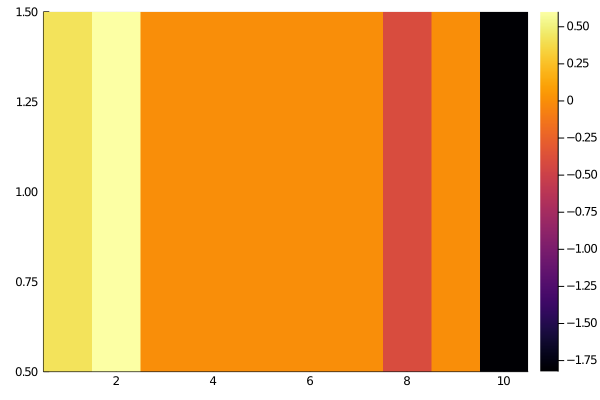

In [39]:
heatmap(G[1:1,:])

In [8]:
@time optimize(M, X, nothing; withqr = true, P = serial)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


  0.321003 seconds (56.81 k allocations: 178.260 MiB, 18.10% gc time)


HermiteMap(10, 100, LinearTransform(100, [-1.9388115412536764, -0.5532840915970996, 0.6649510381692495, 0.8066244424946927, 1.4603598696781142, -1.4589681336803537, -0.9824037374192759, -0.20679245486456055, -1.1291131135026242, 0.6906625282794049  …  -0.37101560389918037, -0.7188384105130516, 1.9141484922491452, -0.41860810828244416, -1.6650320190314736, 1.410747568280138, -1.9536171293522333, 0.2517759861817628, -1.3866687836217055, 0.16619895667801496], [1.003333887605085 0.0 … 0.0 0.0; 0.0 0.889799322434419 … 0.0 0.0; … ; 0.0 0.0 … 1.0213865816432859 0.0; 0.0 0.0 … 0.0 0.9260049299342631], true), MapComponent[MapComponent(10, 10, 1, IntegratedFunction(10, 10, 1, Rectifier("softplus"), ParametricFunction(ExpandedFunction(10, 10, 1, MultiBasis(Basis of 10 functions: Constant -> 8th degree Probabilistic Hermite function
, 1), [1; 2; … ; 9; 10], [0.09564406871613584, -1.5235117095029267, 0.14859370117804918, -4.413286558881069, 0.6568369757672253, -3.796396743470617, 0.7444250305312987

In [ ]:
@time for i=1:Nx
    @show i
    hess_x_log_pdf(M.C[i], X[1:i,:])
end


In [ ]:
@time hess_x_log_pdf(M, X)

i = 1
i = 2
i = 3
i = 

### Integration

In [186]:
Nx = 100
Ny = 50
m = 20
Ne = 400
X = randn(Nx, Ne).*randn(Nx, Ne) #.+ 0.5*randn(Nx).*cos.(randn(Nx, Ne) .* randn(Nx, Ne))

# L = LinearTransform(X)
# transform!(L, X);
# C = MapComponent(m, Nx)
# @time C, _ = optimize(C, X, 10)

In [187]:
M = HermiteMap(m, X);

In [188]:
@time M_noqr = optimize(M, X, 10; P = serial, start = Ny+1);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:13


 19.530544 seconds (69.35 M allocations: 14.972 GiB, 7.45% gc time)


In [189]:
@time M_qr = optimize(M, X, 10; P = serial, withqr = true, start = Ny+1);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


 10.677751 seconds (44.03 M allocations: 13.718 GiB, 9.93% gc time)


In [31]:
function timing()
    M = HermiteMap(m, X)
    @btime begin 
        optimize($M, $X, $10; P = serial, withqr = false, start = Ny+1)
    end
    
    @btime begin 
        optimize($M, $X, $10; P = serial, withqr = true, start = Ny+1)
    end
end

timing (generic function with 1 method)

In [32]:
timing();

  11.257 s (42606958 allocations: 13.65 GiB)
  21.346 s (45813192 allocations: 21.12 GiB)


In [11]:
timing();

  14.597 s (42433511 allocations: 13.37 GiB)


In [29]:
timing();

  973.450 ms (1054425 allocations: 1.43 GiB)


In [14]:
methods(update_component)

# 1 method for generic function "update_component":
[1] update_component(C::MapComponent, X, reduced_margin::Array{Int64,2}, S::Storage) in AdaptiveTransportMap at /media/mat/HDD/AdaptiveTransportMap/src/mapcomponent/greedyfit.jl:249

In [30]:
function timing()
    @btime begin 
        M = HermiteMap($m, $X)
        optimize($M, $X, $10; P = thread)
    end
end

timing (generic function with 1 method)

In [88]:
timing();

  297.730 ms (1000725 allocations: 1.35 GiB)


### Test optimization with QR

In [45]:
Nx = 3
Ne = 8
m = 20

idx = [0 0 0; 0 0 1; 0 1 0; 0 1 1; 0 1 2; 1 0 0]


Nψ = 6
coeff = [ 0.20649582065364197;
         -0.5150990160472986;
          2.630096893080717;
          1.13653076177397;
          0.6725837371023421;
         -1.3126095306624133]
C = MapComponent(m, Nx, idx, coeff; α = 1e-6);

Ne = 100


# The QR decomposition is not unique!

X = randn(Nx, Ne) .* randn(Nx, Ne) + cos.(randn(Nx, Ne)) .* exp.(-randn(Nx, Ne).^2)

L = LinearTransform(X)
transform!(L, X)
S = Storage(C.I.f, X)
F = QRscaling(S)
newidx = [1 1 1]

Snew = update_storage(S, X, newidx)
Fupdated = updateQRscaling(F, Snew)

Fnew = QRscaling(Snew)

@test norm(Fupdated.D - Fnew.D)<1e-8
@test norm(Fupdated.Dinv - Fnew.Dinv)<1e-8

Test Passed